In [1]:
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow.keras as tfk 
import tensorflow.keras.layers as tfkl 
plt.rc('font', size=16) 
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn import preprocessing 


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [2]:
# Random seed for reproducibility
seed = 89
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
path = r'/kaggle/input/dataset-hw2-ann/'
x_train = np.load(path + r'x_train.npy')
y_train = np.load(path + r'y_train.npy')

# Dataset visualization

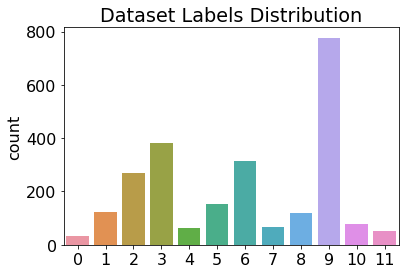

In [4]:
# plot labels distribution 
sns.countplot( x = y_train) 
plt.title('Dataset Labels Distribution')
plt.show()

In [5]:
# setting up 
labels = np.unique(np.fromiter([i for i in y_train], np.int32) )
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=labels, y=y_train) 

In [6]:
from scipy.interpolate import interp1d
x_new = [] 
for el in x_train: 
    interp = interp1d(x=np.arange(36), y=el, axis=0, kind='cubic')
    el = interp(np.arange(0, 35, .3))
    x_new.append(el)
x_new = np.array(x_new) 
print(x_new.shape) 
x_train = x_new

(2429, 117, 6)


In [7]:
# split 
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=seed, stratify=y_train) 
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape )

(1943, 117, 6) (1943,) (486, 117, 6) (486,)


In [9]:
y_train = tfk.utils.to_categorical(y_train) 
y_test = tfk.utils.to_categorical(y_test)

In [11]:
train_data = np.concatenate([x for x in x_train]) 
print(train_data.shape) 
scaler = preprocessing.RobustScaler().fit(train_data) #robust scaler best to time, outliers? 

x_train_trans = [] 
for el in x_train: 
    x_train_trans.append(scaler.transform(el))
del x_train 

x_test_trans = [] 
for el in x_test :
    x_test_trans.append(scaler.transform(el))

x_train = np.asarray(x_train_trans) 
x_test = np.asarray(x_test_trans)

(227331, 6)


In [12]:
print(x_train.shape, y_train.shape)

(1943, 117, 6) (1943, 12)


Resampling

2022-12-15 12:05:40.580049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 12:05:40.675913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 12:05:40.676924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 12:05:40.681284: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

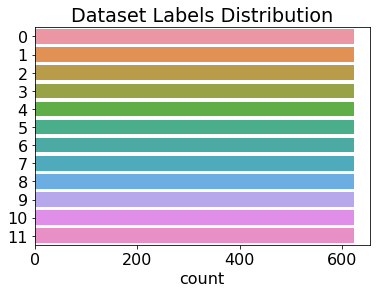

(7464, 702) (7464, 12)
(7464, 117, 6) (7464, 12)


In [13]:
OLD_SHAPE = x_train.shape[1]
x_train_reshaped = tf.reshape(x_train, shape = (x_train.shape[0], x_train.shape[1]*6) )
#print(x_train_reshaped.shape, y_train.shape)  
from imblearn.over_sampling import RandomOverSampler, SVMSMOTE, SMOTE

ros = SMOTE(sampling_strategy='not majority' ,random_state=seed)
train_data, labels = ros.fit_resample(x_train_reshaped, y_train)

plotting_labels = np.argmax(labels, axis = 1)
sns.countplot( y = plotting_labels) 
plt.title('Dataset Labels Distribution')
plt.show()

print(train_data.shape, labels.shape) 
x_res = tf.reshape(train_data, shape = (train_data.shape[0], OLD_SHAPE, 6) ) #PUT NEW SIZE HERE 
y_res = labels #from above 
print(x_res.shape, y_res.shape)

In [17]:
X = x_res 
Y = y_res

print(X.shape, Y.shape) 
input_shape = (OLD_SHAPE,6)

(7464, 117, 6) (7464, 12)


In [18]:
from sklearn.utils import shuffle 
X = np.reshape(X, X.shape)
X, Y = shuffle(X, Y)

# Network

In [19]:
def build_ffnn_classifier(input_shape, classes):
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    x = input_layer
        
    cnn_1 = tfkl.Conv1D(256,3,padding='same',activation='relu')(x) 
    cnn = tfkl.MaxPooling1D()(cnn_1)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    
    x = tfkl.MultiHeadAttention( key_dim=6, num_heads=5, dropout=0.2 )(cnn,tfkl.MaxPool1D(strides = 2)(input_layer) )
    x = tfkl.Add()([cnn, tfkl.MaxPool1D(strides = 4)(cnn_1) ])
    gap = tfkl.GlobalAveragePooling1D()(x)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)


    hidden_layer1 = tfkl.Dense(units=256, activation ='relu', name = 'Hidden1', kernel_regularizer = tfk.regularizers.L2(l2 = 0.0003))(dropout) 
    hidden_layer2 = tfkl.Dense(units=256, activation ='relu', name = 'Hidden2', kernel_regularizer = tfk.regularizers.L2(l2 = 0.0001))(hidden_layer1) 
    
    output_layer = tfkl.Dense(classes, activation='softmax', 
                              kernel_initializer=tfk.initializers.GlorotUniform(seed))(hidden_layer2)
      
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model

In [20]:
model = build_ffnn_classifier(input_shape, 12)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 117, 6)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 117, 256)     4864        Input[0][0]                      
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 58, 256)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 58, 256)      196864      max_pooling1d[0][0]              
______________________________________________________________________________________________

In [22]:
history1 = model.fit(
    x = X,
    y = Y,
    batch_size = 64,
    epochs = 300,
    validation_data = (x_test, y_test),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=40, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=30, factor=0.2, min_lr=1e-5)
    ]
).history

Epoch 1/300


2022-12-15 12:05:44.347806: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-15 12:05:46.092947: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


117/117 [==============================] - 9s 10ms/step - loss: 2.5633 - accuracy: 0.2907 - val_loss: 2.3607 - val_accuracy: 0.2366
Epoch 2/300
117/117 [==============================] - 1s 6ms/step - loss: 1.9144 - accuracy: 0.4109 - val_loss: 1.9992 - val_accuracy: 0.2901
Epoch 3/300
117/117 [==============================] - 1s 7ms/step - loss: 1.7473 - accuracy: 0.4649 - val_loss: 1.8516 - val_accuracy: 0.3210
Epoch 4/300
117/117 [==============================] - 1s 6ms/step - loss: 1.5785 - accuracy: 0.5080 - val_loss: 1.8984 - val_accuracy: 0.3704
Epoch 5/300
117/117 [==============================] - 1s 8ms/step - loss: 1.4621 - accuracy: 0.5421 - val_loss: 1.7015 - val_accuracy: 0.3909
Epoch 6/300
117/117 [==============================] - 1s 6ms/step - loss: 1.2765 - accuracy: 0.5856 - val_loss: 1.7031 - val_accuracy: 0.4177
Epoch 7/300
117/117 [==============================] - 1s 6ms/step - loss: 1.2053 - accuracy: 0.6212 - val_loss: 1.3870 - val_accuracy: 0.4959
Epoch 8/30

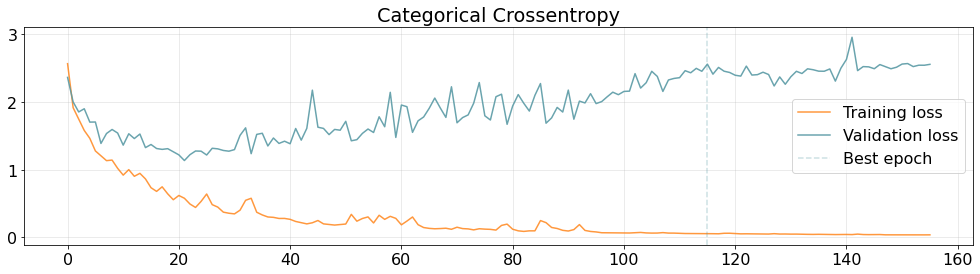

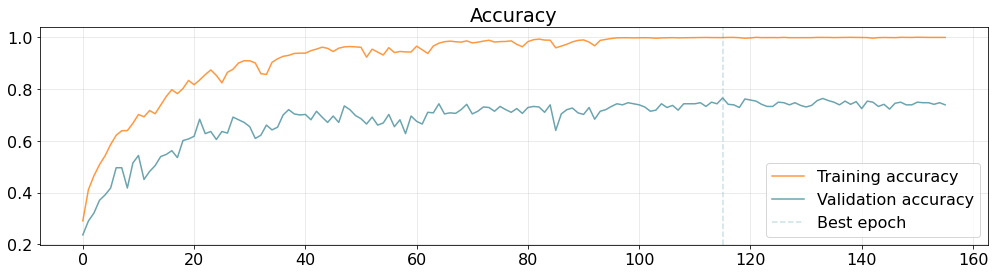

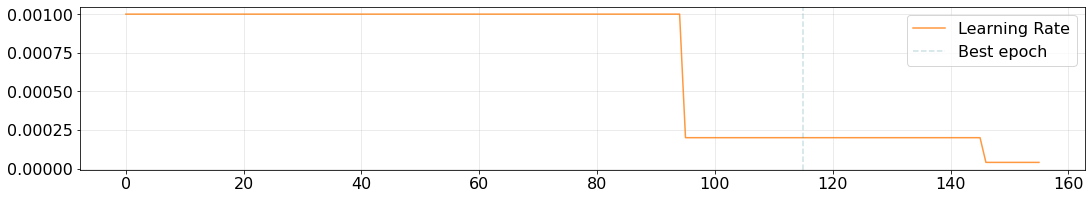

In [23]:
best_epoch = np.argmax(history1['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history1['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history1['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history1['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history1['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history1['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

16/16 [==============================] - 0s 2ms/step - loss: 0.0510 - accuracy: 0.0000e+00
{'loss': 0.05104183778166771, 'accuracy': 0.0}
Accuracy: 0.7654
Precision: 0.7009
Recall: 0.6165
F1: 0.637
F1 (per class): [0.6        0.74074074 0.95327103 0.55474453 0.31578947 0.44897959
 0.92307692 0.47619048 0.875      0.81920904 0.9375     0.        ]


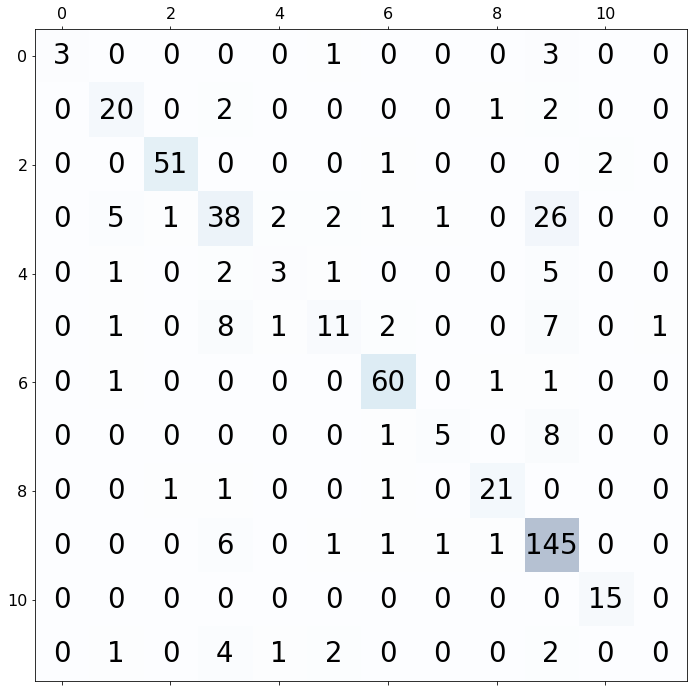

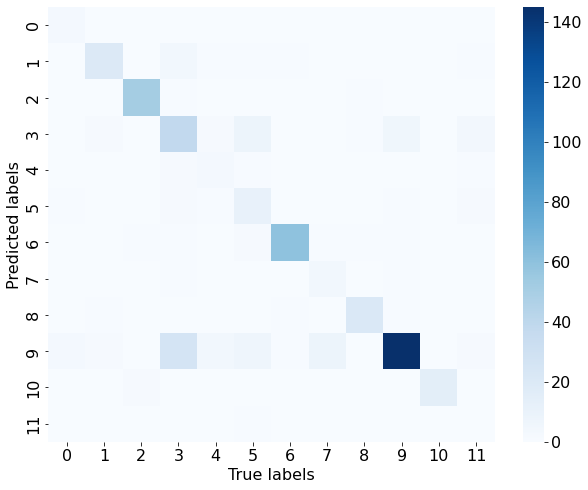

In [24]:
metrics = model.evaluate(x_test, return_dict=True)
print(metrics)

labels = y_test 
predictions = model.predict(x_test) 
assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):' ,f1_classes)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(12,12))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [25]:
model.save('sub5')

2022-12-15 12:08:10.334992: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [26]:
import pickle 
with open(r'scaler', 'wb') as f: 
    pickle.dump(scaler, f)